In [2]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import KeyedVectors
import pandas as pd
from sklearn.model_selection import cross_val_score, learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import warnings

In [3]:
import numpy as np
np.random.seed(42)  # Set random seed for numpy

import random
random.seed(42)  # Set random seed for random module

In [3]:
# df = pd.read_csv("D:\\MS DATA SCIENCE\\NLP TESE\\data\\data_processed_selected.csv")
# df.head()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/MyDrive/MS DATA SCIENCE /TESE /data_processed_selected.csv")

In [5]:
def preprocess_entities(row):
    if pd.isna(row)==False:
        entities = row.lower()  # Convert to lowercase
        entities = entities.replace(',', '')  # Remove commas
        entities = ' '.join(set(entities.split()))  # Convert to set to get unique values, then join back as a string
        return entities
df['entities'] = df['entities'].apply(preprocess_entities)

In [6]:
df['entities']

0                          israel aboboda ctt
1                                        None
2                               roissy frança
3        inglés el lisboa correio corte verde
4                                        None
                         ...                 
22425                unido portugal ctt reino
22426                                    None
22427                              aliexpress
22428                                  lisboa
22429                                    None
Name: entities, Length: 22430, dtype: object

In [7]:
df.columns

Index(['date', 'title', 'reason', 'description', 'zone', 'narrative_tfidf',
       'narrative_embeddings', 'narrative_bert', 'narrative_tfidf_title',
       'narrative_bert_title', 'narrative_embeddings_title', 'tfidf_title',
       'title_tfidf_nolemma', 'events', 'keywords', 'embeddings_title',
       'tfidf_keywords', 'embeddings_keywords', 'events_clean',
       'results_final', 'events_tfidf', 'events_embeddings', 'orgs', 'locs',
       'entities'],
      dtype='object')

In [8]:
y=df['reason']
X = df[['narrative_embeddings', 'embeddings_title', 'events_embeddings', 'entities']]

In [9]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

# Print the shape of each set
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (15701, 4)
y_train shape: (15701,)
X_val shape: (3364, 4)
y_val shape: (3364,)
X_test shape: (3365, 4)
y_test shape: (3365,)


In [10]:
X_train_val = pd.concat([X_train, X_val], axis=0, ignore_index=True)
y_train_val = pd.concat([y_train, y_val], axis=0, ignore_index=True)

In [11]:
def embeddings_transformation(X_train_val_combined,X_test_combined,model):
    # initiating a sentence with all zeros
    embedding_size = 600
    X_train_val_transformed = np.zeros((len(X_train_val_combined), embedding_size))
    X_test_transformed = np.zeros((len(X_test_combined), embedding_size))

    # Loop over each string in X_train_combined and X_val_combined
    for i, sentence in enumerate(X_train_val_combined):
        # Loop over each word in the sentence and, if it is in the model's vocabulary, add its feature vector to the total
        embeddings = [model[word] for word in sentence.split() if word in model]
        if embeddings:
            X_train_val_transformed[i] = np.mean(embeddings, axis=0)

    for i, sentence in enumerate(X_test_combined):
        # Loop over each word in the sentence and, if it is in the model's vocabulary, add its feature vector to the total
        embeddings = [model[word] for word in sentence.split() if word in model]
        if embeddings:
            X_test_transformed[i] = np.mean(embeddings, axis=0)

    return X_train_val_transformed, X_test_transformed

In [13]:
glove= KeyedVectors.load_word2vec_format('/content/drive/MyDrive/MS DATA SCIENCE /TESE /glove_s600.txt')

In [14]:
glove

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
# Plot Learning Curves
def plot_learning_curve(best_model, X_train_val_combined_transformed, y_train_val, scoring):
    # Create StratifiedKFold cross-validator with 6 folds
    stratified_cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

    train_sizes, train_scores, val_scores = learning_curve(best_model, X_train_val_combined_transformed, y_train_val, cv=stratified_cv,
                                                           scoring=scoring, train_sizes=np.linspace(0.1, 1.0, 10),
                                                           random_state=42, n_jobs=-1, verbose=3)

    # Calculate mean and standard deviation of training and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(val_scores, axis=1)
    valid_scores_std = np.std(val_scores, axis=1)

    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color='blue')
    plt.plot(train_sizes, valid_scores_mean, label='Cross-validation score', color='red')
    plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.2, color='red')
    plt.xlabel('Number of Training Examples')
    plt.ylabel('{} Score'.format(scoring))
    plt.title('Learning Curves')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [17]:
# combine in the same string
feature_set=['narrative_embeddings', 'embeddings_title']
X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

# mean of the sentence embeddings
X_train_transformed, X_test_transformed= embeddings_transformation(X_train_val_combined,X_test_combined,glove)

# **1. LinearSVC**   

multiple param_grids because some hyperparameters are not compatible:
* l1 only works with squared_hinge and dual=False
* l2 works with both hinge and squared_hinge, but:
* l2 and hinge only work with dual=True
* l2 and squared_hinge work with both dual=True or dual=False
* dual = True if number of features > number of examples
* C>0

## LinearSVC() HT

In [18]:
# Define multiple hyperparameter grids
param_grid_1 = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
    'loss': ['squared_hinge'],
    'penalty': ['l1'],
    'dual': [False],
    'max_iter': [5000, 6000, 7000, 8000, 9000, 10000]
}

param_grid_2 = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
    'loss': ['hinge'],
    'penalty': ['l2'],
    'dual': [True],
    'max_iter': [5000, 6000, 7000, 8000, 9000, 10000]
}

param_grid_3 = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
    'loss': ['squared_hinge'],
    'penalty': ['l2'],
    'dual': [True, False],
    'max_iter': [5000, 6000, 7000, 8000, 9000, 10000]
}

# Combine the hyperparameter grids into a list
param_grids = [param_grid_1, param_grid_2, param_grid_3]

In [ ]:
# Create the stratified 6-fold cross-validation splitter for validation data
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

# or perform RandomizedSearchCV with cross-validation on the validation set
classifier= LinearSVC(random_state=42)
random_search = RandomizedSearchCV(classifier, param_distributions=param_grids, n_iter=40, scoring='f1_macro',
                                   cv=cv, random_state=42, n_jobs=-1, verbose=3)

random_search.fit(X_train_transformed, y_train_val)


# Get the best model with tuned hyperparameters
best_model = random_search.best_estimator_
print("best mean cross-validation f1-score: {:.3f}".format(random_search.best_score_))
print("Best Hyperparameters:", random_search.best_params_)

Fitting 6 folds for each of 40 candidates, totalling 240 fits
best mean cross-validation f1-score: 0.438
Best Hyperparameters: {'penalty': 'l2', 'max_iter': 6000, 'loss': 'squared_hinge', 'dual': False, 'C': 100.0}


In [ ]:
params=random_search.best_params_
best_model= LinearSVC(random_state=42, **params)

In [ ]:
# Perform cross-validation for different metrics
metrics = ['f1_macro', 'accuracy', 'recall_macro', 'precision_macro']
for metric in metrics:
    cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
    scores = cross_val_score(best_model, X_train_transformed, y_train_val, cv=cv, scoring=metric, n_jobs=-1, verbose=3)
    print("Individual {} scores:".format(metric), scores)
    print("Mean cross-validation {}:".format(metric), scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Individual f1_macro scores: [0.44164864 0.42983925 0.45858978 0.4365517  0.42484703 0.43488076]
Mean cross-validation f1_macro: 0.43772619429435683


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Individual accuracy scores: [0.64694777 0.64443046 0.65103839 0.64368901 0.64746616 0.65187284]
Mean cross-validation accuracy: 0.6475741046787209


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Individual recall_macro scores: [0.43485289 0.42729513 0.44841026 0.43533153 0.42476366 0.43412929]
Mean cross-validation recall_macro: 0.4341304584434413
Individual precision_macro scores: [0.54506886 0.51961913 0.5715852  0.53885692 0.49055875 0.51512711]
Mean cross-validation precision_macro: 0.5301359960195398


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.9min finished


In [ ]:
plot_learning_curve(best_model, X_train_transformed, y_train_val, 'accuracy')

In [ ]:
plot_learning_curve(best_model, X_train_transformed, y_train_val, 'f1_macro')

test classification report
              precision    recall  f1-score   support

           0       0.57      0.63      0.60      1195
           1       0.40      0.05      0.09       333
           2       0.71      0.85      0.77      1609
           3       0.48      0.20      0.28       228

    accuracy                           0.65      3365
   macro avg       0.54      0.43      0.43      3365
weighted avg       0.62      0.65      0.61      3365



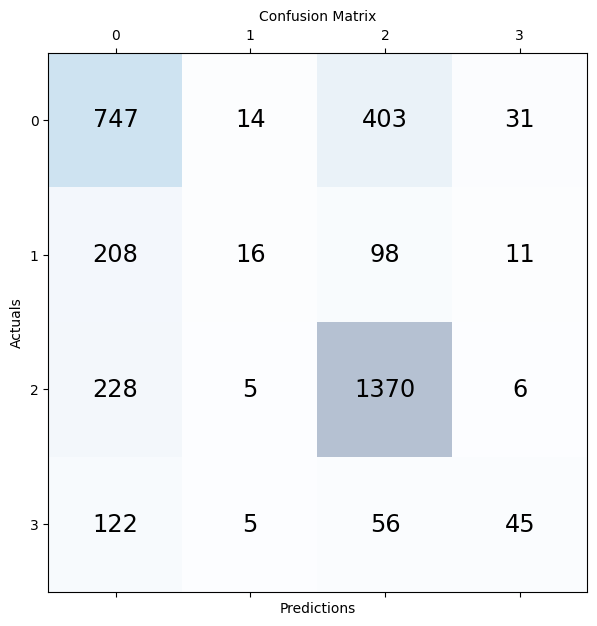

In [ ]:
# test set evaluation
# Retrain on full training set using the best hyperparameters
best_model.fit(X_train_transformed, y_train_val)
# Make predictions on the test dataset
y_pred_test = best_model.predict(X_test_transformed)
print('test classification report')
print(classification_report(y_test, y_pred_test))

# Print the confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
confusion_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_test, labels=[0,1,2,3])
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()
print('\n')

## LinearSVC with Class Weighting HT
https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html  

In the context of LinearSVC in scikit-learn, the class_weight parameter allows you to control the penalty applied to different classes during model training. It adjusts the parameter C of the Support Vector Classification (SVC) for each class, which influences the trade-off between maximizing the margin and minimizing the classification error for that class.

'balanced': When you set class_weight='balanced', the model automatically adjusts the weights inversely proportional to the class frequencies in the input data. In other words, it will assign higher weights to the minority classes and lower weights to the majority classes.

class weights: Some algorithms allow you to assign different weights to classes during training. By giving higher weights to the minority classes, you can make the model focus more on learning from these classes.

In [22]:
# Create the stratified 6-fold cross-validation splitter for validation data
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
# or perform RandomizedSearchCV with cross-validation on the validation set
classifier= LinearSVC(class_weight='balanced', random_state=42)
random_search = RandomizedSearchCV(classifier, param_distributions=param_grids, n_iter=40,
                                   scoring='f1_macro', cv=cv, random_state=42, n_jobs=-1, verbose=3)

random_search.fit(X_train_transformed, y_train_val)

# Get the best model with tuned hyperparameters
best_model = random_search.best_estimator_
print("best mean cross-validation f1-score: {:.3f}".format(random_search.best_score_))
print("Best Hyperparameters:", random_search.best_params_)

Fitting 6 folds for each of 40 candidates, totalling 240 fits
best mean cross-validation f1-score: 0.493
Best Hyperparameters: {'penalty': 'l2', 'max_iter': 6000, 'loss': 'squared_hinge', 'dual': True, 'C': 1.0}


In [23]:
params=random_search.best_params_
best_model= LinearSVC(class_weight='balanced', random_state=42, **params)
# Perform cross-validation for different metrics
metrics = ['f1_macro', 'accuracy']
for metric in metrics:
    cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
    scores = cross_val_score(best_model, X_train_transformed, y_train_val, cv=cv, scoring=metric, n_jobs=-1, verbose=3)
    print("Individual {} scores:".format(metric), scores)
    print("Mean cross-validation {}:".format(metric), scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  4.2min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  4.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Individual f1_macro scores: [0.48960121 0.48568252 0.502974   0.46930146 0.504618   0.50468374]
Mean cross-validation f1_macro: 0.4928101564751784


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  4.2min remaining:  4.2min


Individual accuracy scores: [0.62083071 0.61485211 0.6277533  0.61315707 0.63613472 0.63298709]
Mean cross-validation accuracy: 0.6242858337990059


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  4.4min finished


In [ ]:
plot_learning_curve(best_model, X_train_transformed, y_train_val, 'f1_macro')

In [ ]:
plot_learning_curve(best_model, X_train_transformed, y_train_val, 'f1_macro')

test classification report
              precision    recall  f1-score   support

           0       0.61      0.52      0.56      1195
           1       0.28      0.20      0.24       333
           2       0.75      0.81      0.78      1609
           3       0.33      0.52      0.40       228

    accuracy                           0.63      3365
   macro avg       0.49      0.51      0.50      3365
weighted avg       0.62      0.63      0.62      3365



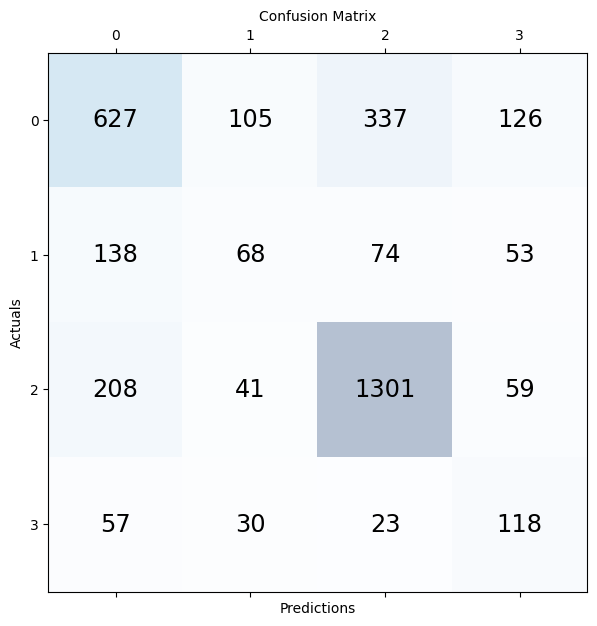

In [24]:
# test set evaluation
# Retrain on full training set using the best hyperparameters
best_model.fit(X_train_transformed, y_train_val)
# Make predictions on the test dataset
y_pred_test = best_model.predict(X_test_transformed)
print('test classification report')
print(classification_report(y_test, y_pred_test))

# Print the confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
confusion_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_test, labels=[0,1,2,3])
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()
print('\n')

## L1 REG + HT

In [25]:
# combine in the same string
feature_set=['narrative_embeddings', 'embeddings_title']
X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

# mean of the sentence embeddings
X_train_transformed, X_test_transformed= embeddings_transformation(X_train_val_combined,X_test_combined,glove)

# L1 Regularization (Lasso) for Linear SVC
svc_model = LinearSVC(penalty='l1', dual=False, random_state=42)
svc_model.fit(X_train_transformed, y_train_val)

# Select features based on non-zero coefficients
feature_selector = SelectFromModel(svc_model)
feature_selector.fit(X_train_transformed, y_train_val)
X_train_val_selected = feature_selector.transform(X_train_transformed)

# New number of features
best_num_features= X_train_val_selected.shape[1]

# Define multiple hyperparameter grids
param_grid_1 = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'loss': ['squared_hinge'],
    'penalty': ['l1'],
    'dual': [False],
    'max_iter': [3000, 4000, 5000, 6000, 7000, 8000, 9000]
}

param_grid_2 = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'loss': ['hinge'],
    'penalty': ['l2'],
    'dual': [True],
    'max_iter': [3000, 4000, 5000, 6000, 7000, 8000, 9000]
}

param_grid_3 = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'loss': ['squared_hinge'],
    'penalty': ['l2'],
    'dual': [True, False],
    'max_iter': [3000, 4000, 5000, 6000, 7000, 8000, 9000]
}

# Combine the hyperparameter grids into a list
param_grids = [param_grid_1, param_grid_2, param_grid_3]

model=LinearSVC(random_state=42)
# Create the stratified 6-fold cross-validation splitter for validation data
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
# or perform RandomizedSearchCV with cross-validation on the validation set
random_search = RandomizedSearchCV(model, param_grids, scoring='f1_macro', cv=cv, random_state=42, n_jobs=-1, verbose=3)
random_search.fit(X_train_val_selected, y_train_val)

Fitting 6 folds for each of 10 candidates, totalling 60 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
                   estimator=LinearSVC(random_state=42), n_jobs=-1,
                   param_distributions=[{'C': [0.001, 0.01, 0.1, 1.0, 10.0,
                                               100.0],
                                         'dual': [False],
                                         'loss': ['squared_hinge'],
                                         'max_iter': [3000, 4000, 5000, 6000,
                                                      7000, 8000, 9000],
                                         'penalty': ['l1']},
                                        {'C': [0.001, 0.01, 0.1, 1.0, 10.0,
                                               100.0],
                                         'dual': [True], 'loss': ['hinge'],
                                         'max_iter': [3000, 4000, 5000, 6000,
                                                      7000, 8000, 9000],
                                         'penalty': ['l2']},
                                        {'C': [0.001, 0.01, 0.1, 1.0, 10.0,
                                               100.0],
                                         'dual': [True, False],
                                         'loss': ['squared_hinge'],
                                         'max_iter': [3000, 4000, 5000, 6000,
                                                      7000, 8000, 9000],
                                         'penalty': ['l2']}],
                   random_state=42, scoring='f1_macro', verbose=3)

In [26]:
print("best mean cross-validation f1-score: {:.3f}".format(random_search.best_score_))
best_model = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)
print("Nr of features before: {}, number of features after: {}".format(X_train_transformed.shape[1],best_num_features))

best mean cross-validation f1-score: 0.437
Best Hyperparameters: {'penalty': 'l2', 'max_iter': 3000, 'loss': 'squared_hinge', 'dual': False, 'C': 100.0}
Nr of features before: 600, number of features after: 563


In [27]:
# Perform cross-validation for different metrics
metrics = ['f1_macro', 'accuracy']
for metric in metrics:
    cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
    scores = cross_val_score(best_model, X_train_val_selected, y_train_val, cv=cv, scoring=metric, n_jobs=-1, verbose=3)
    print("Individual {} scores:".format(metric), scores)
    print("Mean cross-validation {}:".format(metric), scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   43.5s remaining:   43.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   47.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Individual f1_macro scores: [0.43935896 0.42774478 0.45402812 0.43456041 0.43078694 0.43625271]
Mean cross-validation f1_macro: 0.43712198718356143


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   39.0s remaining:   39.0s


Individual accuracy scores: [0.6500944  0.64285714 0.64883575 0.64620711 0.64935474 0.6521876 ]
Mean cross-validation accuracy: 0.6482561227946909


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   45.4s finished


In [ ]:
plot_learning_curve(best_model, X_train_val_selected, y_train_val, 'accuracy')

In [ ]:
plot_learning_curve(best_model, X_train_val_selected, y_train_val, 'f1_macro')

test classification report
              precision    recall  f1-score   support

           0       0.57      0.62      0.59      1195
           1       0.36      0.04      0.08       333
           2       0.71      0.85      0.77      1609
           3       0.46      0.18      0.25       228

    accuracy                           0.64      3365
   macro avg       0.52      0.42      0.42      3365
weighted avg       0.61      0.64      0.61      3365



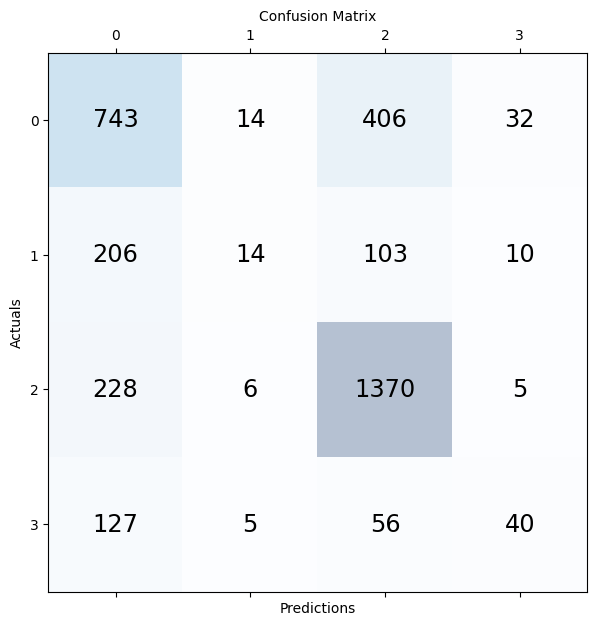

In [28]:
# Retrain on full training set using the best hyperparameters
best_model.fit(X_train_val_selected, y_train_val)

X_test_selected = feature_selector.transform(X_test_transformed)
# Make predictions on the test dataset
y_pred_test = best_model.predict(X_test_selected)
print('test classification report')
print(classification_report(y_test, y_pred_test))

# Print the confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
confusion_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_test, labels=[0,1,2,3])
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()
print('\n')

## SMOTE + HT

In [22]:
import os

num_cpus = os.cpu_count()
print(f"Number of CPUs: {num_cpus}")

Number of CPUs: 8


In [18]:
# combine in the same string
feature_set=['narrative_embeddings', 'embeddings_title']
X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

# mean of the sentence embeddings
X_train_transformed, X_test_transformed= embeddings_transformation(X_train_val_combined,X_test_combined,glove)

# Step 3: Initialize SMOTE and apply it only to the minority classes
smote=SMOTE(random_state=42, sampling_strategy='not majority')
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_transformed, y_train_val)

In [21]:
# Create the stratified 6-fold cross-validation splitter for validation data
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

# or perform RandomizedSearchCV with cross-validation on the validation set
classifier= LinearSVC(random_state=42)
random_search = RandomizedSearchCV(classifier, param_distributions=param_grids, n_iter=40, scoring='f1_macro',
                                   cv=cv, random_state=42, n_jobs=-1, verbose=3)

random_search.fit(X_train_balanced, y_train_balanced)


# Get the best model with tuned hyperparameters
best_model = random_search.best_estimator_


Fitting 6 folds for each of 40 candidates, totalling 240 fits


In [22]:
print("best mean cross-validation f1-score: {:.3f}".format(random_search.best_score_))
print("Best Hyperparameters:", random_search.best_params_)

best mean cross-validation f1-score: 0.626
Best Hyperparameters: {'penalty': 'l1', 'max_iter': 6000, 'loss': 'squared_hinge', 'dual': False, 'C': 10.0}


In [19]:
params={'penalty': 'l1', 'max_iter': 6000, 'loss': 'squared_hinge', 'dual': False, 'C': 10.0}
best_model= LinearSVC(random_state=42, **params)

In [24]:
# Perform cross-validation for different metrics
metrics = ['f1_macro', 'accuracy']
for metric in metrics:
    cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
    scores = cross_val_score(best_model, X_train_balanced, y_train_balanced, cv=cv, scoring=metric, n_jobs=-1,verbose=3)
    print("Individual {} scores:".format(metric), scores)
    print("Mean cross-validation {}:".format(metric), scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed: 58.5min remaining: 58.5min


Individual f1_macro scores: [0.61961093 0.62811068 0.62496588 0.62436345 0.62558038 0.63565151]
Mean cross-validation f1_macro: 0.6263804723972316


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 58.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed: 57.7min remaining: 57.7min


Individual accuracy scores: [0.63042763 0.63684211 0.63497286 0.63299885 0.63431485 0.64599441]
Mean cross-validation accuracy: 0.6359251173510764


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 58.3min finished


[learning_curve] Training set sizes: [ 3039  6079  9118 12158 15198 18237 21277 24316 27356 30396]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  60 | elapsed: 94.4min remaining: 203.7min
[Parallel(n_jobs=-1)]: Done  40 out of  60 | elapsed: 198.4min remaining: 99.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 307.2min finished


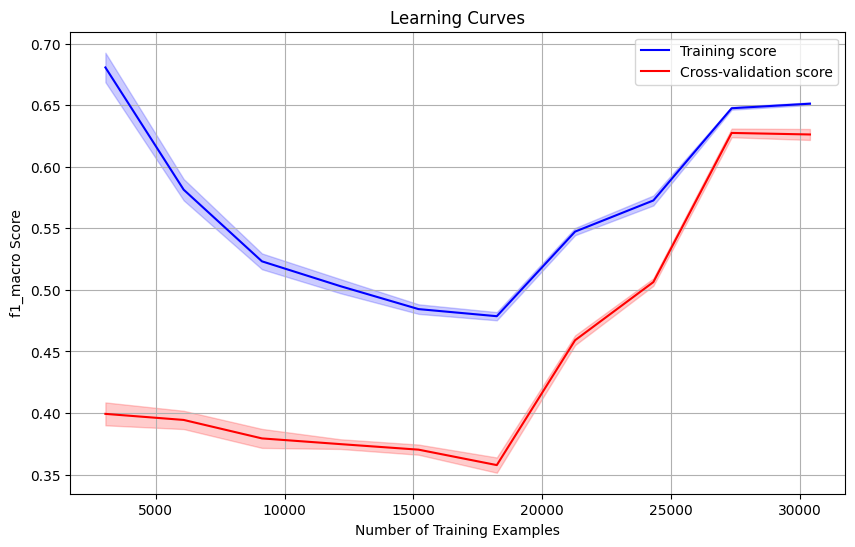

In [25]:
plot_learning_curve(best_model, X_train_balanced, y_train_balanced, 'f1_macro')

[learning_curve] Training set sizes: [ 3039  6079  9118 12158 15198 18237 21277 24316 27356 30396]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  60 | elapsed: 92.7min remaining: 200.0min
[Parallel(n_jobs=-1)]: Done  40 out of  60 | elapsed: 195.2min remaining: 97.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 304.8min finished


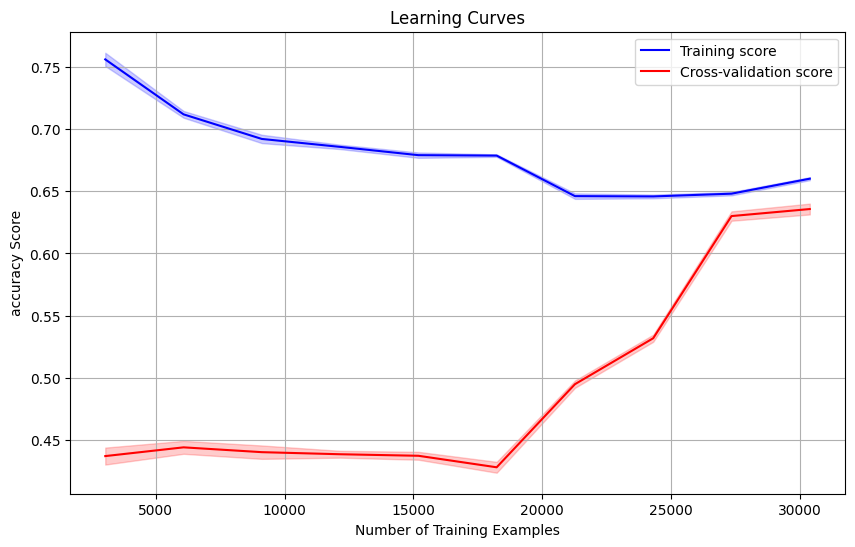

In [26]:
plot_learning_curve(best_model, X_train_balanced, y_train_balanced, 'accuracy')

test classification report
              precision    recall  f1-score   support

           0       0.60      0.35      0.44      1195
           1       0.25      0.41      0.31       333
           2       0.76      0.76      0.76      1609
           3       0.24      0.53      0.33       228

    accuracy                           0.56      3365
   macro avg       0.46      0.51      0.46      3365
weighted avg       0.62      0.56      0.57      3365



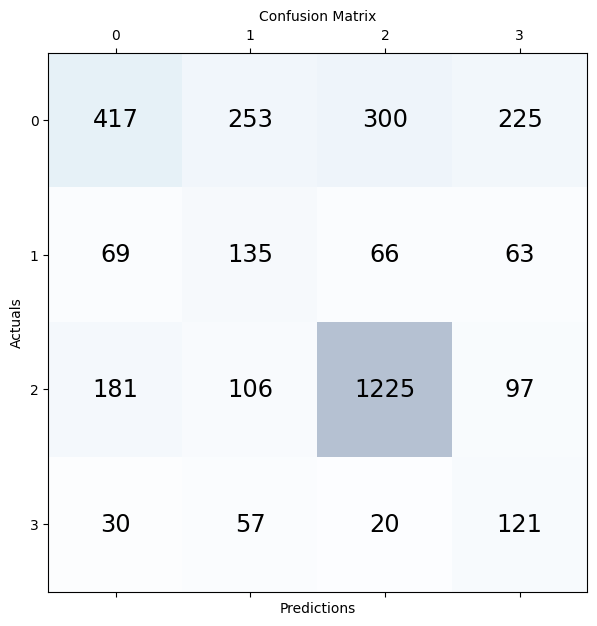

In [20]:
# Retrain on full training set using the best hyperparameters
best_model.fit(X_train_balanced, y_train_balanced)

# Make predictions on the test dataset
y_pred_test = best_model.predict(X_test_transformed)
print('test classification report')
print(classification_report(y_test, y_pred_test))

# Print the confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
confusion_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_test, labels=[0,1,2,3])
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()
print('\n')

## LinearSVC coef + HT